In [1]:
## Import packages to read in data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%matplotlib inline

In [2]:
%%time

## Data does not have column headers, add these when importing

column_labels = ['transaction_ID', 'price', 'transfer_date', 'postcode','property_type', 
              'new_build','duration', 'PAON', 'SAON', 'street', 'locality', 'town_city', 
              'district', 'county', 'PPD_category_type', 'record_status']

## Read in the UK Housing Prices Paid 2018 dataset
## requires chunking as it is a large file

df_chunk = pd.read_csv("/Users/user/Desktop/Datasets/pp-2018.csv", names=column_labels,
                      iterator=True, chunksize=10000)

## concatenate the chunks into one DataFrame 
chunk_list = []  # append each chunk here 

# Each chunk is in df format
for chunk in df_chunk:      
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk)
    
# concat the list into dataframe 
df = pd.concat(chunk_list)

CPU times: user 8.59 s, sys: 2.02 s, total: 10.6 s
Wall time: 12.2 s


In [3]:
## As we are interested in only selected columns, restructure the data for these columns
## exclude transaction ID, secondary address (SAON), PPD category type, and record status
df = df.drop(columns = ['transaction_ID', 'SAON', 'PPD_category_type', 'record_status'])

In [4]:
## Convert transfer date to DateTime object
df['transfer_date'] = pd.to_datetime(df.transfer_date)

## Add month and year columns
df['month'] = df['transfer_date'].dt.month
df['year'] = df['transfer_date'].dt.year

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023150 entries, 0 to 1023149
Data columns (total 14 columns):
price            1023150 non-null int64
transfer_date    1023150 non-null datetime64[ns]
postcode         1017226 non-null object
property_type    1023150 non-null object
new_build        1023150 non-null object
duration         1023150 non-null object
PAON             1023150 non-null object
street           1003520 non-null object
locality         385531 non-null object
town_city        1023150 non-null object
district         1023150 non-null object
county           1023150 non-null object
month            1023150 non-null int64
year             1023150 non-null int64
dtypes: datetime64[ns](1), int64(3), object(10)
memory usage: 109.3+ MB


### Filter the data by specific criteria

In [5]:
## Explore the data with different criteria
criteria01 = df.price > 1000000
criteria02 = df.new_build == 'Y'

## Return a table, with selected columns, based on those criteria
df_query = df[criteria01 & criteria02].reset_index()
df_query[['price', 'property_type', 'new_build','town_city']].head()

,price,property_type,new_build,town_city
0,1325000,D,Y,BISHOP'S STORTFORD
1,1250000,D,Y,HARPENDEN
2,1425000,D,Y,BISHOP'S STORTFORD
3,1150000,F,Y,WINCHESTER
4,1200000,D,Y,BISHOP'S STORTFORD


In [6]:
## Summary statistics of dataset
avg_price = np.mean(df.price)
median_price = np.median(df.price)

print("Overall 2018 average price was : £" + format(avg_price, ",.0f"))
print("Overall 2018 median price was : £" + format(median_price, ",.0f"))

## Average price paid in London
city_select = 'London'
avg_price_paid = round(df[df.town_city == city_select.upper()].price.mean(), 2)
print("Average 2018 price paid in " + city_select + " was: £" + format(avg_price_paid, ",.0f"))

Overall 2018 average price was : £349,707
Overall 2018 median price was : £230,000
Average 2018 price paid in London was: £1,019,656


### Compare multiple cities prices paid

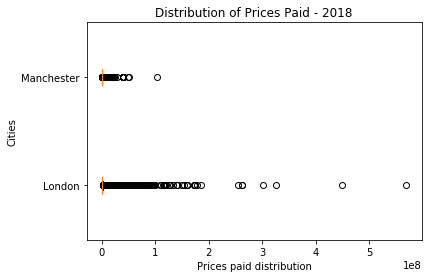

In [7]:
city_option01 = 'London'
city_option02 = 'Manchester'

city01 = df[df['town_city'] == city_option01.upper()]
city02 = df[df['town_city'] == city_option02.upper()]

plt.boxplot([city01.price, city02.price], labels=[city_option01, city_option02], 
            autorange=True, widths=0.15, vert=False)
plt.title('Distribution of Prices Paid - 2018')
plt.xlabel('Prices paid distribution')
plt.ylabel('Cities')
plt.show()

In [111]:
## Preprocess data for regression analysis
## by converting cateogories into numerical values

## Create new column that trims the postcodes into generalized postcodes (remove last 3 charaacters)
df['trim_postcode'] = [str(x)[:-4] for x in df.postcode.tolist()]

# Create a new dictionary of only unique generalized postcodes
p = df.trim_postcode.unique()
unique_postcodes = dict(np.ndenumerate(p))
# Flip the keys and values to get a numerical value for each unique generalized postcode
unique_postcodes = {y:x for x,y in unique_postcodes.items()}

# Assign the unique number of postcode to each instance (or row) in DataFrame
df['prep_postcode'] = [unique_postcodes[x] for x in df.trim_postcode]
# Then trim the values of non-numerical characters
df['prep_postcode'] = [str(x)[1:-2] for x in df['prep_postcode']]
# To convert it to an integer for use in the model
df['prep_postcode'].astype(int)

0             0
1             1
2             2
3             3
4             4
5             5
6             6
7             7
8             7
9             7
10            8
11            9
12            4
13           10
14           11
15           12
16           13
17           14
18            4
19           15
20           16
21           17
22            4
23            7
24           13
25           18
26           19
27           20
28            4
29           13
           ... 
1023120     175
1023121      30
1023122      34
1023123     837
1023124      36
1023125    1205
1023126      34
1023127     837
1023128     174
1023129     650
1023130     172
1023131     650
1023132     182
1023133     837
1023134     921
1023135     599
1023136      40
1023137     649
1023138      34
1023139     837
1023140      29
1023141      29
1023142     822
1023143      30
1023144      34
1023145     648
1023146     645
1023147      42
1023148     837
1023149      29
Name: prep_postcode, Len

In [112]:
## Create new columns to enumerate the string data in Property Type and New Build columns
prep_prop_type = {'D' : 1, 
                  'S' : 2, 
                  'T' : 3, 
                  'F' : 4, 
                  'O' : 5}

prep_new_build = {'N': 0, 
                  'Y': 1}

df['prep_prop_type'] = [prep_prop_type[x] for x in df.property_type]
df['prep_new_build'] = [prep_new_build[x] for x in df.new_build]

In [113]:
# Now we can put all the new numerical columns together
df[['price','prep_prop_type', 'prep_new_build', 'prep_postcode']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023150 entries, 0 to 1023149
Data columns (total 4 columns):
price             1023150 non-null int64
prep_prop_type    1023150 non-null int64
prep_new_build    1023150 non-null int64
prep_postcode     1023150 non-null object
dtypes: int64(3), object(1)
memory usage: 31.2+ MB


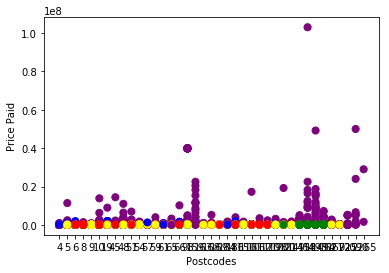

In [123]:
# City for graph
city = 'Manchester'

# random number representing size
x1 = df[df['town_city'] == city.upper()].prep_postcode

# generate random array of property types
x2 = df[df['town_city'] == city.upper()].property_type

# random number representing price
y = df[df['town_city'] == city.upper()].price

# create mapping from property type to matplot colour
property_type_colour_map = {'D' : 'blue', 
                            'S' : 'red', 
                            'T' : 'yellow', 
                            'F' : 'green', 
                            'O' : 'purple'}

# create array of colours from list comprehension
colour_array = [property_type_colour_map[i] for i in x2]

plt.scatter(x1, y, c=colour_array, s=50)
plt.xticks()
plt.yticks()
plt.xlabel('Postcodes')
plt.ylabel('Price Paid')
plt.show()